In [45]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [46]:
data_dir = "C:/Users/vigne/Desktop/CW2_ML_PDE4433/Dataset/" 
categories = ["M5_bolt", "M6_bolt", "M8_bolt","M12_bolt","M5_nut","M6_nut","M8_nut","M12_nut"]
img_size = 224

In [47]:
def load_data():
    data = []
    labels = []
    for category in categories:
        path = os.path.join(data_dir, category)
        label = categories.index(category)  
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)

                gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
                blurred = cv2.GaussianBlur(gray, (19, 19), 5)
                _, thresh = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY)
                edges = cv2.Canny(thresh, 100, 200)

                kernel = np.ones((5, 5), np.uint8)
                dilated = cv2.dilate(edges, kernel, iterations=2)
                eroded = cv2.erode(dilated, kernel, iterations=1)

                contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # Process only if we have at least one valid contour
                for cnt in contours:
                    area = cv2.contourArea(cnt)
                    if area > 100:  # Filter small areas
                        x, y, w, h = cv2.boundingRect(cnt)
                        cropped = img_array[y:y+h, x:x+w]

                        output_size = 244
                        white_bg = np.ones((output_size, output_size, 3), dtype=np.uint8) * 255

                        # Ensure cropped size fits
                        ch, cw = cropped.shape[:2]
                        if ch <= output_size and cw <= output_size:
                            y_offset = (output_size - ch) // 2
                            x_offset = (output_size - cw) // 2

                            white_bg[y_offset:y_offset+ch, x_offset:x_offset+cw] = cropped

                            # Resize to final model input size
                            final_img = cv2.resize(white_bg, (img_size, img_size))

                            data.append(final_img)
                            labels.append(label)

                        break
            except Exception as e:
                print(f"Error loading image: {e}")
    return np.array(data), np.array(labels)

In [48]:
X, y = load_data()
X = X.reshape(-1, img_size, img_size, 3) / 255.0  
y = tf.keras.utils.to_categorical(y, num_classes=len(categories)) 
print(X.shape,y.shape)

(264, 224, 224, 3) (264, 8)


In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
model = Sequential([
    Input(shape=(img_size, img_size, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')
])


In [51]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=100, batch_size=16, callbacks=[early_stop])

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - accuracy: 0.1576 - loss: 19.7937 - val_accuracy: 0.1132 - val_loss: 2.1004
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.2491 - loss: 2.0219 - val_accuracy: 0.5094 - val_loss: 1.6250
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.6170 - loss: 1.3958 - val_accuracy: 0.8302 - val_loss: 0.6278
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.8773 - loss: 0.4610 - val_accuracy: 0.9057 - val_loss: 0.3520
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.9322 - loss: 0.2113 - val_accuracy: 0.8868 - val_loss: 0.2365
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.9616 - loss: 0.1140 - val_accuracy: 0.9057 - val_loss: 0.3756
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.9800 - loss: 0.1058 - val_accuracy: 0.9245 - val_loss: 0.1899
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.9940 - loss: 0.0347 - val_acc

In [53]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9414 - loss: 0.1216
Test Accuracy: 94.34%


In [54]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      51,380,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,205,786 (588.25 MB)

 Trainable params: 51,401,928 (196.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 102,803,858 (392.17 MB)

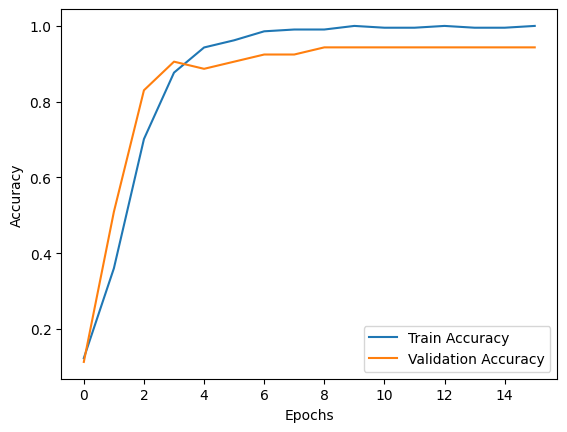

In [55]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [56]:
model.save("bolt_nut_classifier.keras",include_optimizer=False)

In [65]:
import cv2
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load trained model
model = tf.keras.models.load_model("bolt_nut_classifier.keras")

# Define categories
categories = ["M5_bolt", "M6_bolt", "M8_bolt", "M12_bolt", "M5_nut", "M6_nut", "M8_nut", "M12_nut"]

# Open Webcam
cap = cv2.VideoCapture(0)

# Set frame width and height
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

while True:
    ret, frame = cap.read()
    if not ret:
        break

        
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (19, 19), 5)
    _, thresh = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY)
    edges = cv2.Canny(thresh, 100, 200)

    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    eroded = cv2.erode(dilated, kernel, iterations=1)

    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Process only if we have at least one valid contour
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 100:  # Optional: Filter small areas
            x, y, w, h = cv2.boundingRect(cnt)
            cropped = frame[y:y+h, x:x+w]

            output_size = 244
            white_bg = np.ones((output_size, output_size, 3), dtype=np.uint8) * 255

            # Ensure cropped size fits
            ch, cw = cropped.shape[:2]
            if ch <= output_size and cw <= output_size:
                y_offset = (output_size - ch) // 2
                x_offset = (output_size - cw) // 2

                white_bg[y_offset:y_offset+ch, x_offset:x_offset+cw] = cropped

                # Resize to final model input size
                final_img = cv2.resize(white_bg, (img_size, img_size))

                # Preprocess the image
                img_processed = preprocess_input(final_img.astype(np.float32))
                img_array = np.expand_dims(img_processed, axis=0)
                
                predictions = model.predict(img_array, verbose=0)
                class_id = np.argmax(predictions)
                confidence = np.max(predictions)

                # Draw rectangle and label
                label = f"{categories[class_id]}"#" ({confidence * 100:.2f}%)"
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Show video feed
    cv2.imshow("Live Detection", frame)

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()
